# ANN(PyTorch) - MNIST
* Project: To classify hand written images from MNIST database
* Project Scope: Create, train an MLP to classify images from MNIST database
* Data source: [MNIST Dataset to download](http://yann.lecun.com/exdb/mnist/). The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples.
* Author: Shashi Kiran Chilukuri

In [1]:
# Data Analysis Libraries
import numpy as np

# Data Visualization library
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch Packages
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

## Load and Visualize data

In [2]:
# Number of subprocesses to use for data loading (parallel processing)
num_workers = 0
# Batch size
batch_size = 20

# Transforms
# In this we are converting the data to torch.FloatTensor
transform = transforms.ToTensor()

# Datasets: train and test
train_data = datasets.MNIST(root ='data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root ='data', train = False, download = True, transform = transform)

# Spliting train dataset into train and validate
validation_size = 0.2
train_len = len(train_data)
indices = list(range(train_len))
np.random.shuffle(indices)
split = int(np.floor(validation_size * train_len))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Dataloader: train, validate, test
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,
                                          sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,
                                          sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize a Batch of Training Data

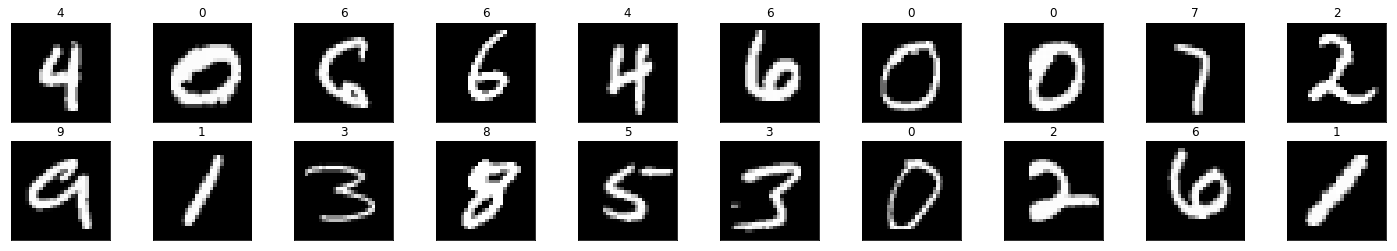

In [3]:
# Obtain a batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# Plotting the images along with the labels
fig = plt.figure(figsize = (25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap ='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(labels[idx].item())
    

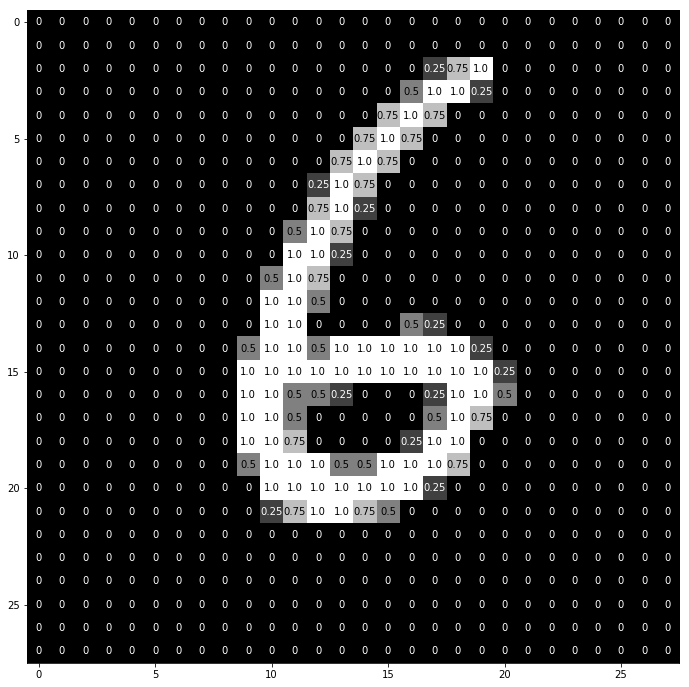

In [4]:
img = np.squeeze(images[3])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Creating Model, Loss function and Optimizer

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self,input_size = (28 * 28), output_size = 10, hidden_layers = [512,512]):
        super(Network, self).__init__()
        
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        self.hidden_layers.extend([nn.Linear(h1,h2) for h1,h2 in zip(hidden_layers[:-1], hidden_layers[1:])])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # adding hidden layer with relu activation function and dropout
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        return x

In [6]:
# Creating model
# import mnist_model
model = Network(input_size = (28 * 28), output_size = 10, hidden_layers = [512,512])

# Loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [7]:
epochs = 50

# initialize minimum validation loss tracker
valid_loss_min = np.Inf # set initial "min" to infinity

for e in range(epochs):
    # moditoring train and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()                              # Enabling the network training mode
    for image, label in train_loader:
        image = image.view(-1,28*28)           # Flatten image input
        optimizer.zero_grad()                  # Clearing previous gradients
        output = model(image)                  # Forward pass: compute predicted outputs
        loss = criterion(output,label)         # Calculating the loss
        loss.backward()                        # Backward pass: Compute gradient of the loss
        optimizer.step()                       # Perform single optimizer step
        train_loss += loss.item()*image.size(0)# updating running training loss
        
    ######################
    # Validate the model #
    ######################
    model.eval()                              # Enabling the network evaluation mode
    for image, label in train_loader:
        image = image.view(-1,28*28)           # Flatten image input
        output = model(image)                  # Forward pass: compute predicted outputs
        loss = criterion(output,label)         # Calculating the loss
        valid_loss += loss.item()*image.size(0)# updating running validation loss
    
    # Printing calculated average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print("Epoch: {}/{} ".format(e+1, epochs),
          "\t Train Loss: {:.4f} ".format(train_loss),
          "\t Valid Loss: {:.4f} ".format(valid_loss))
    
    # Save the model if the validation loss has descreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased from {:.4f} --> {:.4f}. SAVING THE MODEL'
              .format(valid_loss_min,valid_loss))
        
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1/50  	 Train Loss: 0.7592  	 Valid Loss: 0.3021 
Validation loss decreased from inf --> 0.3021. SAVING THE MODEL
Epoch: 2/50  	 Train Loss: 0.2876  	 Valid Loss: 0.2256 
Validation loss decreased from 0.3021 --> 0.2256. SAVING THE MODEL
Epoch: 3/50  	 Train Loss: 0.2266  	 Valid Loss: 0.1825 
Validation loss decreased from 0.2256 --> 0.1825. SAVING THE MODEL
Epoch: 4/50  	 Train Loss: 0.1879  	 Valid Loss: 0.1519 
Validation loss decreased from 0.1825 --> 0.1519. SAVING THE MODEL
Epoch: 5/50  	 Train Loss: 0.1591  	 Valid Loss: 0.1274 
Validation loss decreased from 0.1519 --> 0.1274. SAVING THE MODEL
Epoch: 6/50  	 Train Loss: 0.1383  	 Valid Loss: 0.1084 
Validation loss decreased from 0.1274 --> 0.1084. SAVING THE MODEL
Epoch: 7/50  	 Train Loss: 0.1219  	 Valid Loss: 0.0972 
Validation loss decreased from 0.1084 --> 0.0972. SAVING THE MODEL
Epoch: 8/50  	 Train Loss: 0.1083  	 Valid Loss: 0.0839 
Validation loss decreased from 0.0972 --> 0.0839. SAVING THE MODEL
Epoch: 9/50

###  Load the Model with the Lowest Validation Loss

In [8]:
model.load_state_dict(torch.load('model.pt'))

In [9]:
#####################
# Testing the model #
#####################
# Initializing the test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()                               # Enabling the network evaluation mode
for image, label in train_loader:
    image = image.view(-1,28*28)           # Flatten image input
    output = model(image)                  # Forward pass: compute predicted outputs
    loss = criterion(output,label)         # Calculating the loss
    test_loss += loss.item()*image.size(0) # updating running validation loss
    
    _, pred = torch.max(output, 1)    # Converting output probabilities to predicted class
    correct = np.squeeze(pred.eq(label.data.view_as(pred))) # compare predictions to true label
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        class_correct[label.data[i]] += correct[i].item()
        class_total[label.data[i]] += 1

# Printing test accuracy for each object class
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %2s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %2s: N/A (no training examples)' % (classes[i]))

# Printing test loss and accuracy
print("Test Loss: {:.4f} ".format(test_loss/len(test_loader.dataset)),
      "Test Accuracy (overall): {:.2f}% ".format(100. * np.sum(class_correct) / np.sum(class_total)))

Test Accuracy of  0: 100% (4757/4757)
Test Accuracy of  1: 99% (5348/5354)
Test Accuracy of  2: 99% (4763/4766)
Test Accuracy of  3: 99% (4949/4951)
Test Accuracy of  4: 99% (4673/4674)
Test Accuracy of  5: 99% (4327/4328)
Test Accuracy of  6: 99% (4742/4743)
Test Accuracy of  7: 99% (4958/4961)
Test Accuracy of  8: 100% (4681/4681)
Test Accuracy of  9: 99% (4780/4785)
Test Loss: 0.0224  Test Accuracy (overall): 99.95% 


### Visualize Sample test resutls

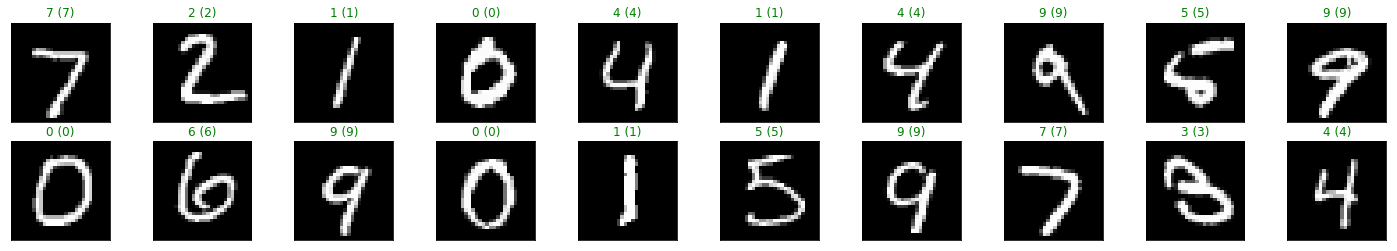

In [26]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images.view(-1,28*28))
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))